## Module Imports

In [1]:
# pandas for data loading, manipulation etc.
import pandas as pd

# numeric functions
import numpy as np
from scipy import stats
from math import ceil

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modelling
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBRegressor

## Load Data

In [2]:
# Load the data
df_train = pd.read_csv('train.csv',index_col='Id')
df_test = pd.read_csv('test.csv',index_col='Id')

# ids of full training dataset (i.e. properties with price information)
id_withprice = df_train.index    

# ids of full test dataset
id_test = df_test.index

# split a holdout set from the training data:
# individual models fit on 80% training data
# ensemble model fit using remaining 20%
shuffle = ShuffleSplit(n_splits=1,test_size=0.2)
for inds in shuffle.split(df_train):
    id_train = df_train.iloc[inds[0]].index
    id_holdout = df_train.iloc[inds[1]].index
    break

# combine train and test datas in to one dataframe
df_all = pd.concat([df_train,df_test])
df_all.head(5)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType BsmtCond  \
Id                                                                        
1        856       854          0   NaN             3     1Fam       TA   
2       1262         0          0   NaN             3     1Fam       TA   
3        920       866          0   NaN             3     1Fam       TA   
4        961       756          0   NaN             3     1Fam       Gd   
5       1145      1053          0   NaN             4     1Fam       TA   

   BsmtExposure  BsmtFinSF1  BsmtFinSF2  ...   SaleType ScreenPorch  Street  \
Id                                       ...                                  
1            No       706.0         0.0  ...         WD           0    Pave   
2            Gd       978.0         0.0  ...         WD           0    Pave   
3            Mn       486.0         0.0  ...         WD           0    Pave   
4            No       216.0         0.0  ...         WD           0    Pave   
5            Av       655.0         0.0  ...         WD           0    Pave   

    TotRmsAbvGrd TotalBsmtSF  Utilities WoodDeckSF YearBuilt YearRemodAdd  \
Id                                                                          
1              8       856.0     AllPub          0      2003         2003   
2              6      1262.0     AllPub        298      1976         1976   
3              6       920.0     AllPub          0      2001         2002   
4              7       756.0     AllPub          0      1915         1970   
5              9      1145.0     AllPub        192      2000         2000   

   YrSold  
Id         
1    2008  
2    2007  
3    2008  
4    2006  
5    2008  

[5 rows x 80 columns]

## Columns with NaN Values

In [3]:
# summary of columns with nan values
#SalePrice nans: test data

cols_with_na = df_all.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64


## Meaningful NaN Values

In [4]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_all[col].fillna('None',inplace=True)
    
#GarageYrBlt nans: no garage. Fill with property YearBuilt.
#(more appropriate than 0, which would be ~2000 away from all other values)
df_all.loc[df_all.GarageYrBlt.isnull(),'GarageYrBlt'] = df_all.loc[df_all.GarageYrBlt.isnull(),'YearBuilt']

#No masonry veneer - fill area with 0
df_all.MasVnrArea.fillna(0,inplace=True)

#No basement - fill areas/counts with 0    
df_all.BsmtFullBath.fillna(0,inplace=True)
df_all.BsmtHalfBath.fillna(0,inplace=True)
df_all.BsmtFinSF1.fillna(0,inplace=True)
df_all.BsmtFinSF2.fillna(0,inplace=True)
df_all.BsmtUnfSF.fillna(0,inplace=True)
df_all.TotalBsmtSF.fillna(0,inplace=True)

#No garage - fill areas/counts with 0
df_all.GarageArea.fillna(0,inplace=True)
df_all.GarageCars.fillna(0,inplace=True)

df_all[cols_fillna].head(5)

PoolQC MiscFeature Alley Fence MasVnrType FireplaceQu GarageQual  \
Id                                                                    
1    None        None  None  None    BrkFace        None         TA   
2    None        None  None  None       None          TA         TA   
3    None        None  None  None    BrkFace          TA         TA   
4    None        None  None  None       None          Gd         TA   
5    None        None  None  None    BrkFace          TA         TA   

   GarageCond GarageFinish GarageType BsmtExposure BsmtCond BsmtQual  \
Id                                                                     
1          TA          RFn     Attchd           No       TA       Gd   
2          TA          RFn     Attchd           Gd       TA       Gd   
3          TA          RFn     Attchd           Mn       TA       Gd   
4          TA          Unf     Detchd           No       Gd       TA   
5          TA          RFn     Attchd           Av       TA       Gd   

   BsmtFinType1 BsmtFinType2  
Id                            
1           GLQ          Unf  
2           ALQ          Unf  
3           GLQ          Unf  
4           ALQ          Unf  
5           GLQ          Unf

## LotFrontage NaN Values

In [5]:
# function to normalise a column of values to lie between 0 and 1
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

----------------
Intercept: 93.208483254
----------------
LotArea             71.475879
RoofMatl_ClyTile    49.396968
1stFlrSF            27.547832
PoolArea            26.905146
RoofStyle_Shed      25.874524
GrLivArea           22.148975
Foundation_Wood     20.075497
LotShape_IR3        17.721471
GarageArea          17.536239
BldgType_2fmCon     16.123235
dtype: float64
----------------
Utilities_AllPub      -11.610027
BldgType_TwnhsE       -12.070870
BsmtCond_Po           -12.151678
Exterior1st_CemntBd   -14.553347
PoolQC_Fa             -14.706527
RoofMatl_WdShake      -15.579127
BldgType_Twnhs        -17.924473
RoofMatl_WdShngl      -18.222015
GarageYrBlt           -21.591319
LotConfig_CulDSac     -23.428742
dtype: float64
----------------
R2: 0.688922936177
----------------


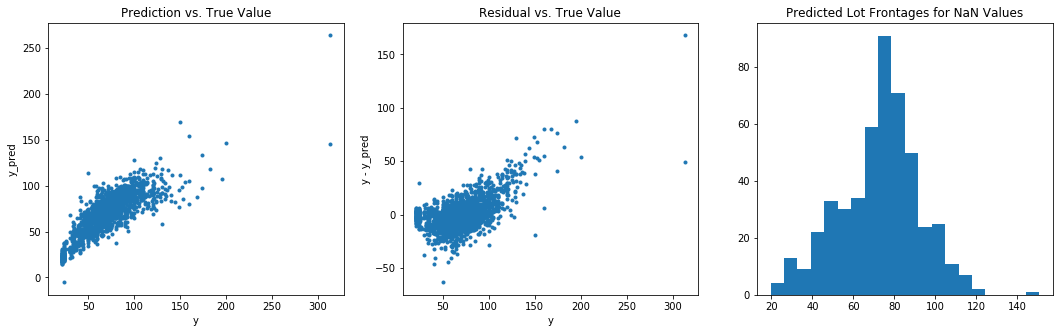

In [6]:
#LotFrontage
# fill nan values using a linear regressor

# convert categoricals to dummies, exclude SalePrice from model
df_frontage = pd.get_dummies(df_all.drop('SalePrice',axis=1))

# normalise columns to 0-1
for col in df_frontage.drop('LotFrontage',axis=1).columns:
    df_frontage[col] = scale_minmax(df_frontage[col])

lf_train = df_frontage.dropna()
lf_train_y = lf_train.LotFrontage
lf_train_X = lf_train.drop('LotFrontage',axis=1)  

# fit model
lr = Ridge()
lr.fit(lf_train_X, lf_train_y)

# check model results
lr_coefs = pd.Series(lr.coef_,index=lf_train_X.columns)

print('----------------')
print('Intercept:',lr.intercept_)
print('----------------')
print(lr_coefs.sort_values(ascending=False).head(10))
print('----------------')
print(lr_coefs.sort_values(ascending=False).tail(10))
print('----------------')
print('R2:',lr.score(lf_train_X,lf_train_y))
print('----------------')

lf_pred_y = lr.predict(lf_train_X)
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(lf_train_y,lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y_pred');
plt.title('Prediction vs. True Value')

plt.subplot(1,3,2)
plt.plot(lf_train_y, lf_train_y-lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');
plt.title('Residual vs. True Value')


# fill na values using model predictions
nan_frontage = df_all.LotFrontage.isnull()
X = df_frontage[nan_frontage].drop('LotFrontage',axis=1)
y = lr.predict(X)

plt.subplot(1,3,3)
plt.hist(y,bins=20)
plt.title('Predicted Lot Frontages for NaN Values')

# fill nan values
df_all.loc[nan_frontage,'LotFrontage'] = y

## Remaining NaNs

In [7]:
# Remaining Nan values
cols_with_na = df_all.drop('SalePrice',axis=1).isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]

print(cols_with_na.sort_values(ascending=False))

rows_with_na = df_all.drop('SalePrice',axis=1).isnull().sum(axis=1)
rows_with_na = rows_with_na[rows_with_na>0]
print(rows_with_na.sort_values(ascending=False))

# fill remaining nans with mode in that column
for col in cols_with_na.index:
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)

MSZoning       4
Utilities      2
Functional     2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
Electrical     1
dtype: int64
Id
2217    2
2152    2
1916    2
2905    1
2490    1
2474    1
2251    1
1946    1
1556    1
1380    1
dtype: int64


In [8]:
# Now no more NaN values apart from SalePrice in test data
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      29

## Categorical Features with Meaningful Ordering

In [9]:
# convert some categorical values to numeric scales

#Excellent, Good, Typical, Fair, Poor, None: Convert to 0-5 scale
cols_ExGd = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond','PoolQC']

dict_ExGd = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

for col in cols_ExGd:
    df_all[col].replace(dict_ExGd, inplace=True)

display(df_all[cols_ExGd].head(5))    

# Remaining columns

df_all['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)

df_all['BsmtFinType1'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0}, inplace=True)
df_all['BsmtFinType2'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0}, inplace=True)

df_all['CentralAir'].replace({'Y':1,'N':0}, inplace=True)

df_all['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)

df_all['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)

df_all['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)

df_all['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)

df_all['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)

ExterQual  ExterCond  BsmtQual  BsmtCond  HeatingQC  KitchenQual  \
Id                                                                     
1           4          3         4         3          5            4   
2           3          3         4         3          5            3   
3           4          3         4         3          5            4   
4           3          3         3         4          4            4   
5           4          3         4         3          5            4   

    FireplaceQu  GarageQual  GarageCond  PoolQC  
Id                                               
1             0           3           3       0  
2             3           3           3       0  
3             3           3           3       0  
4             4           3           3       0  
5             3           3           3       0

## Identify Types of Features

In [10]:
# extract names of numeric columns
dtypes = df_all.dtypes
cols_numeric = dtypes[dtypes != object].index.tolist()

# MSubClass should be treated as categorical
cols_numeric.remove('MSSubClass')

# choose any numeric column with less than 13 values to be
# "discrete". 13 chosen to include months of the year.
# other columns "continuous"
col_nunique = dict()

for col in cols_numeric:
    col_nunique[col] = df_all[col].nunique()
    
col_nunique = pd.Series(col_nunique)

cols_discrete = col_nunique[col_nunique<13].index.tolist()
cols_continuous = col_nunique[col_nunique>=13].index.tolist()

print(len(cols_numeric),'numeric columns, of which',
      len(cols_continuous),'are continuous, and',
      len(cols_discrete),'are discrete.')

55 numeric columns, of which 24 are continuous, and 31 are discrete.


In [11]:
# extract names of categorical columns
cols_categ = dtypes[~dtypes.index.isin(cols_numeric)].index.tolist()

for col in cols_categ:
    df_all[col] = df_all[col].astype('category')
    
print(len(cols_categ),'categorical columns.')

25 categorical columns.


## Distribution of SalePrice

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


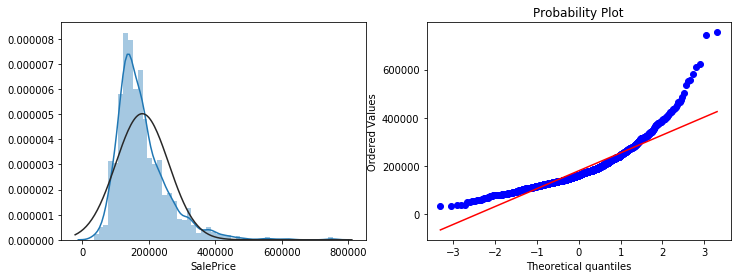

In [12]:
print(df_all.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(df_all.SalePrice.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(df_all.SalePrice.dropna(), plot=plt)

## Log Transform SalePrice

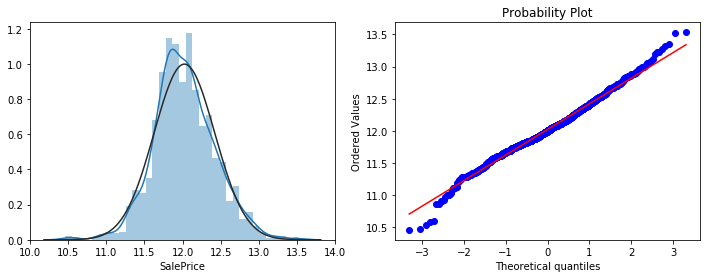

In [13]:
#Log Transform SalePrice to improve normality
sp = df_all.SalePrice
df_all.SalePrice = np.log1p(sp)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(sp.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(sp.dropna(), plot=plt)

## Distribution of SalePrice in Categorical Variables

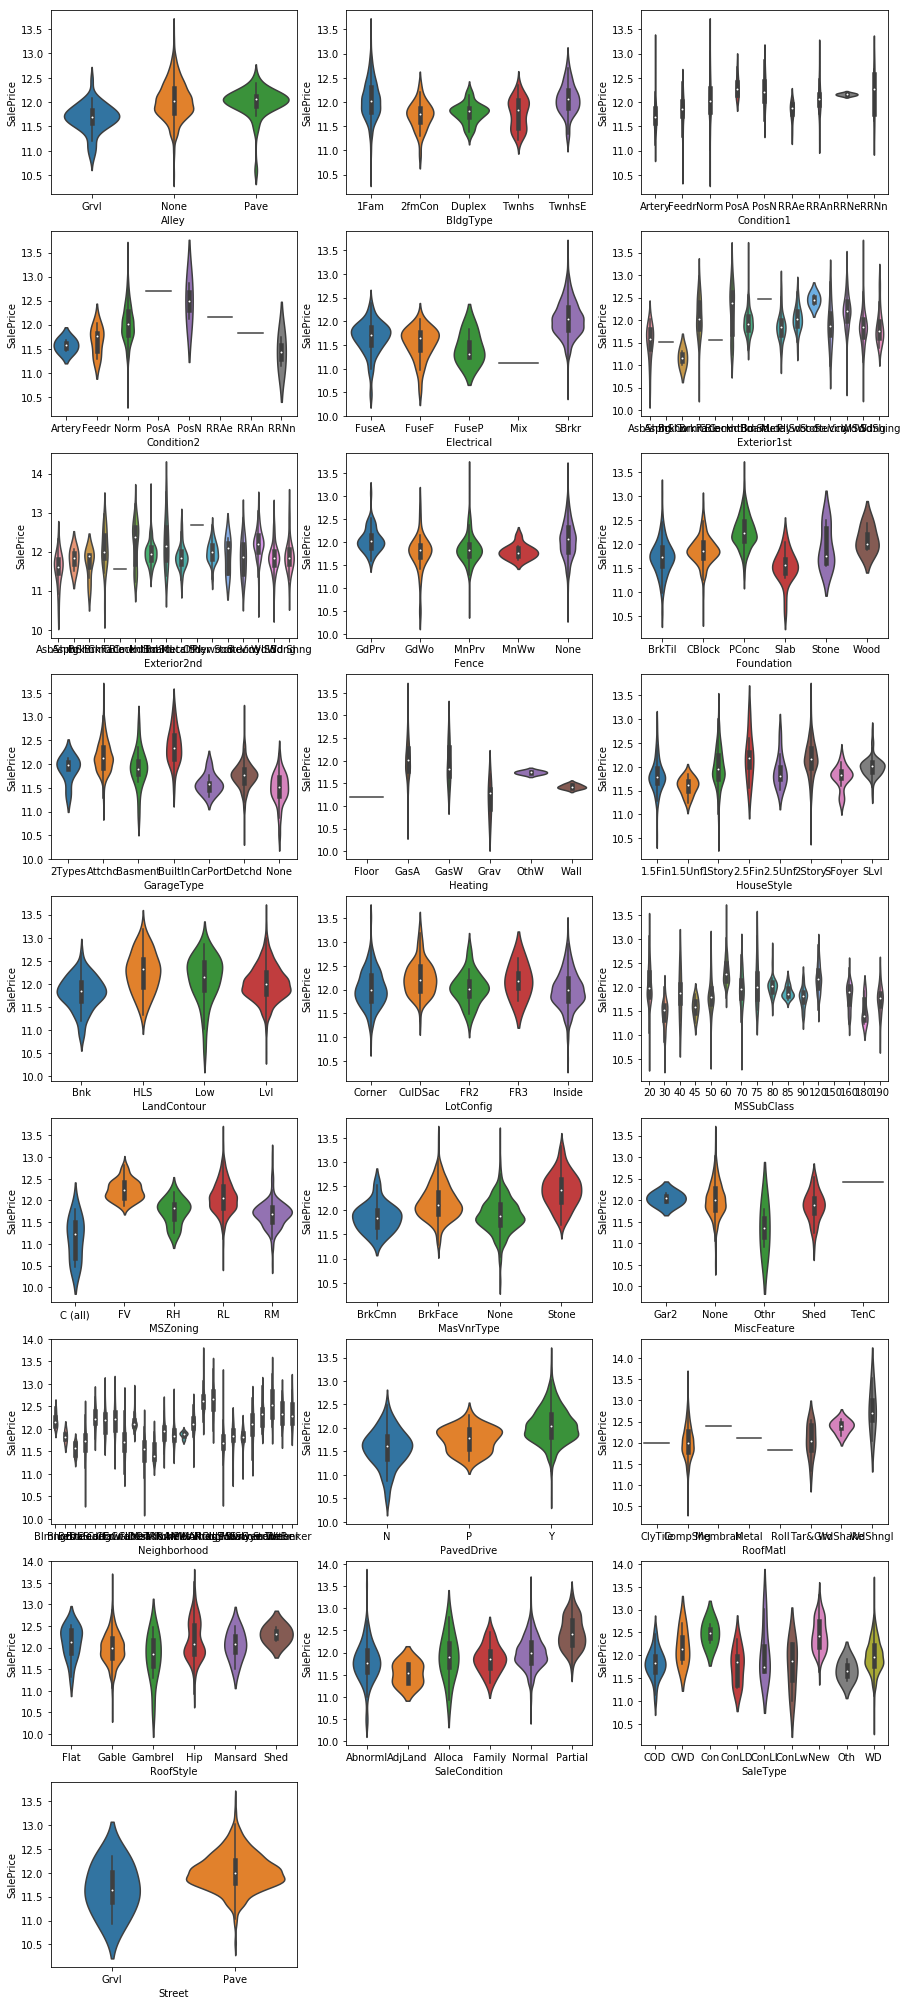

In [14]:
# plot categorical variables
fcols = 3
frows = ceil(len(cols_categ)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_categ):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

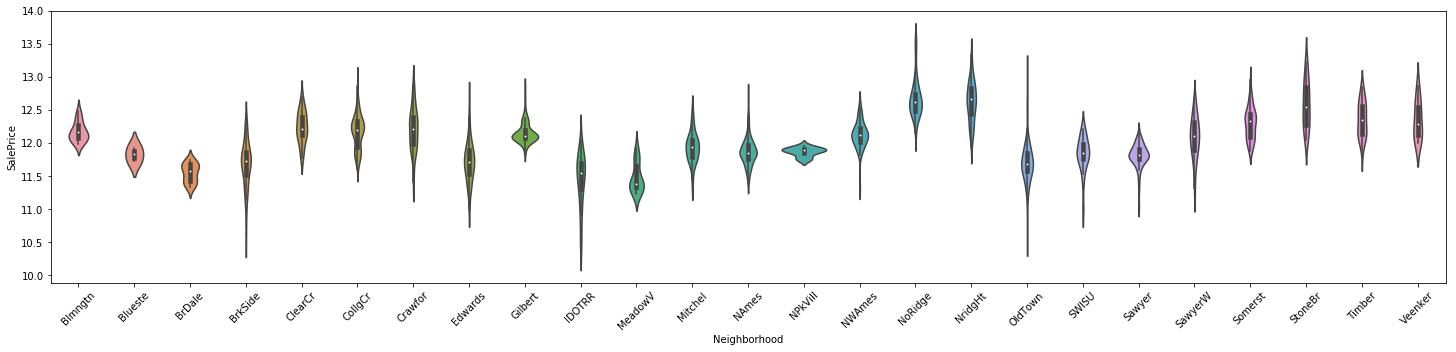

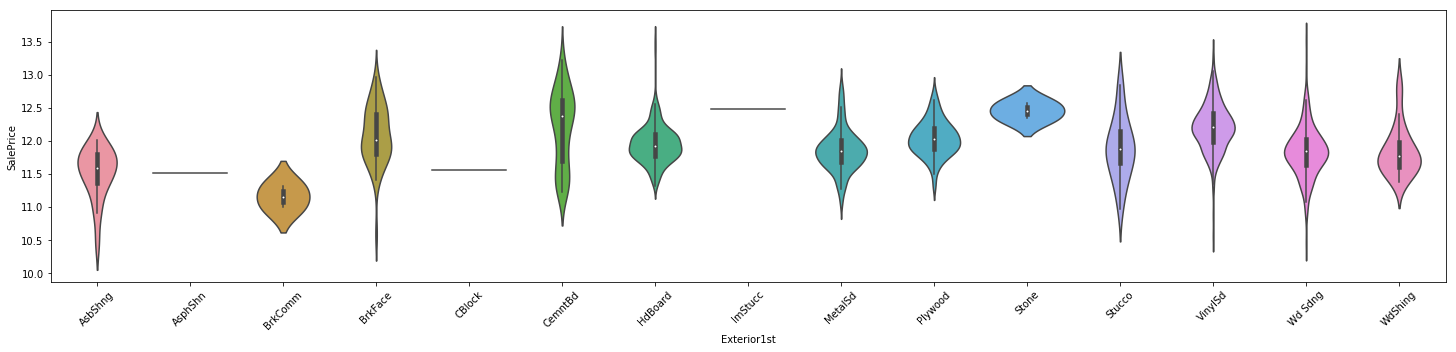

In [15]:
# few bigger plots for features with two many categories to see above

#Neighbourhood
plt.figure(figsize=(25,5))
sns.violinplot(x='Neighborhood',y='SalePrice',data=df_all)
plt.xticks(rotation=45);

#Exterior1st
plt.figure(figsize=(25,5))
sns.violinplot(x='Exterior1st',y='SalePrice',data=df_all)
plt.xticks(rotation=45);

## Significance of Categorical Features for SalePrice

In [16]:
# anova test to check significance of variation between groups
def anova(group,value):
    # select columns of interest, and remove any rows with nan values
    data = df_all[[group,value]]
    data = data[~(data[group].isnull() | data[value].isnull())]
    
    # stats across all data
    tot_groups = data[group].nunique() # no. of groups
    len_data = len(data) # total sample size of house (all groups)
    mean_data = data[value].mean() # mean across all groups
    df_betwn = tot_groups - 1 # degrees of freedom betwn grps
    df_within = len_data - tot_groups # degrees of freedom within grps
    
    # per group stats
    n_in_group = data.groupby(group)[value].count() # no. houses in group
    mean_group = data.groupby(group)[value].mean() # mean value in this group
    
    # between-group variability
    betwn_var = n_in_group*((mean_group - mean_data)**2)
    betwn_var = float(betwn_var.sum())/df_betwn
    
    # within-group variability
    within_var = 0
    for grp in data[group].unique():
        samples = data.loc[data[group]==grp, value]
        within_var += ((samples-mean_group[grp])**2).sum()
        
    within_var = float(within_var)/df_within
    
    #F-test statistic
    F = betwn_var/within_var
    
    # p-value
    p = stats.f.sf(F, df_betwn, df_within)
    
    return p
        

In [17]:
# check significance of categorical variables on SalePrice
p_col = dict()

for col in cols_categ:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

Neighborhood     4.041201e-243
GarageType       8.430356e-125
MSSubClass       5.097264e-115
Foundation       1.350599e-111
MasVnrType        1.669801e-65
MSZoning          1.021737e-59
Exterior1st       1.053089e-53
Exterior2nd       2.429749e-49
SaleCondition     1.689524e-41
SaleType          5.496893e-36
PavedDrive        1.091245e-31
Electrical        6.082296e-31
HouseStyle        1.636014e-30
Fence             6.560268e-13
RoofStyle         1.705634e-12
BldgType          3.436708e-12
Condition1        1.173445e-10
Alley             1.358127e-09
Heating           2.484634e-09
LandContour       3.086154e-08
LotConfig         6.214548e-07
RoofMatl          4.504077e-04
MiscFeature       6.060004e-03
Condition2        1.382043e-02
Street            2.837965e-02
dtype: float64

## Distribution of Numeric Variables and Effect on SalePrice

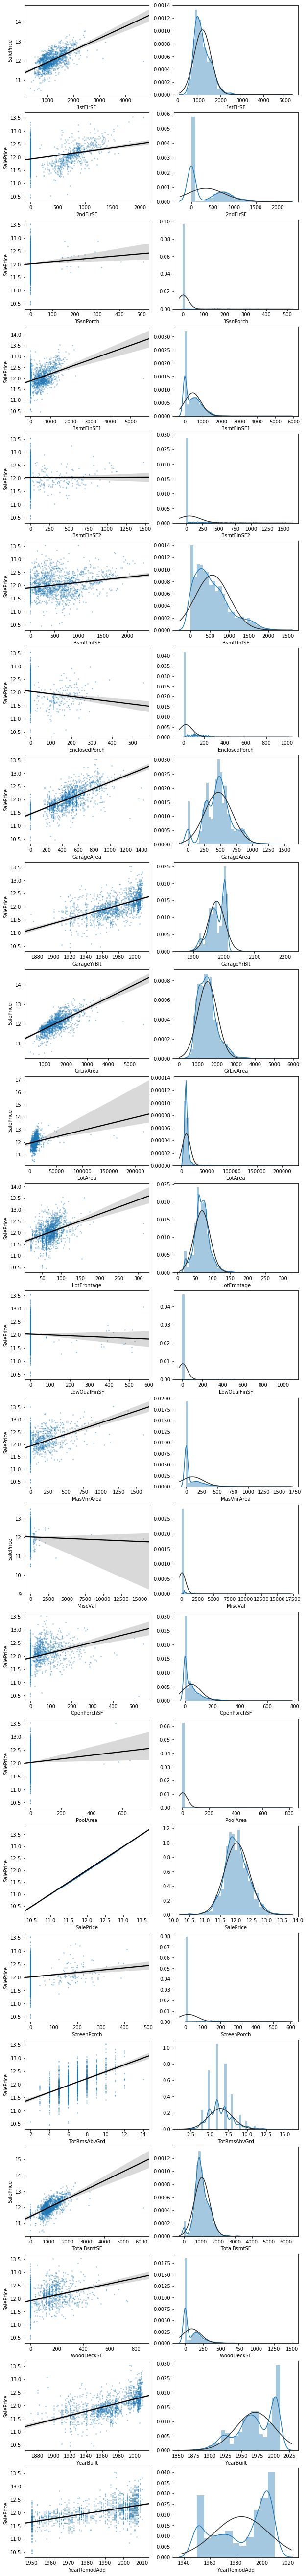

In [18]:
# plot numeric values

fcols = 2
frows = len(cols_continuous)
plt.figure(figsize=(5*fcols,4*frows))

i=0
for col in cols_continuous:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col, y='SalePrice', data=df_all, ax=ax, 
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(df_all[col].dropna() , fit=stats.norm)
    plt.xlabel(col)

## Distribution of SalePrice in Discrete Numeric Features

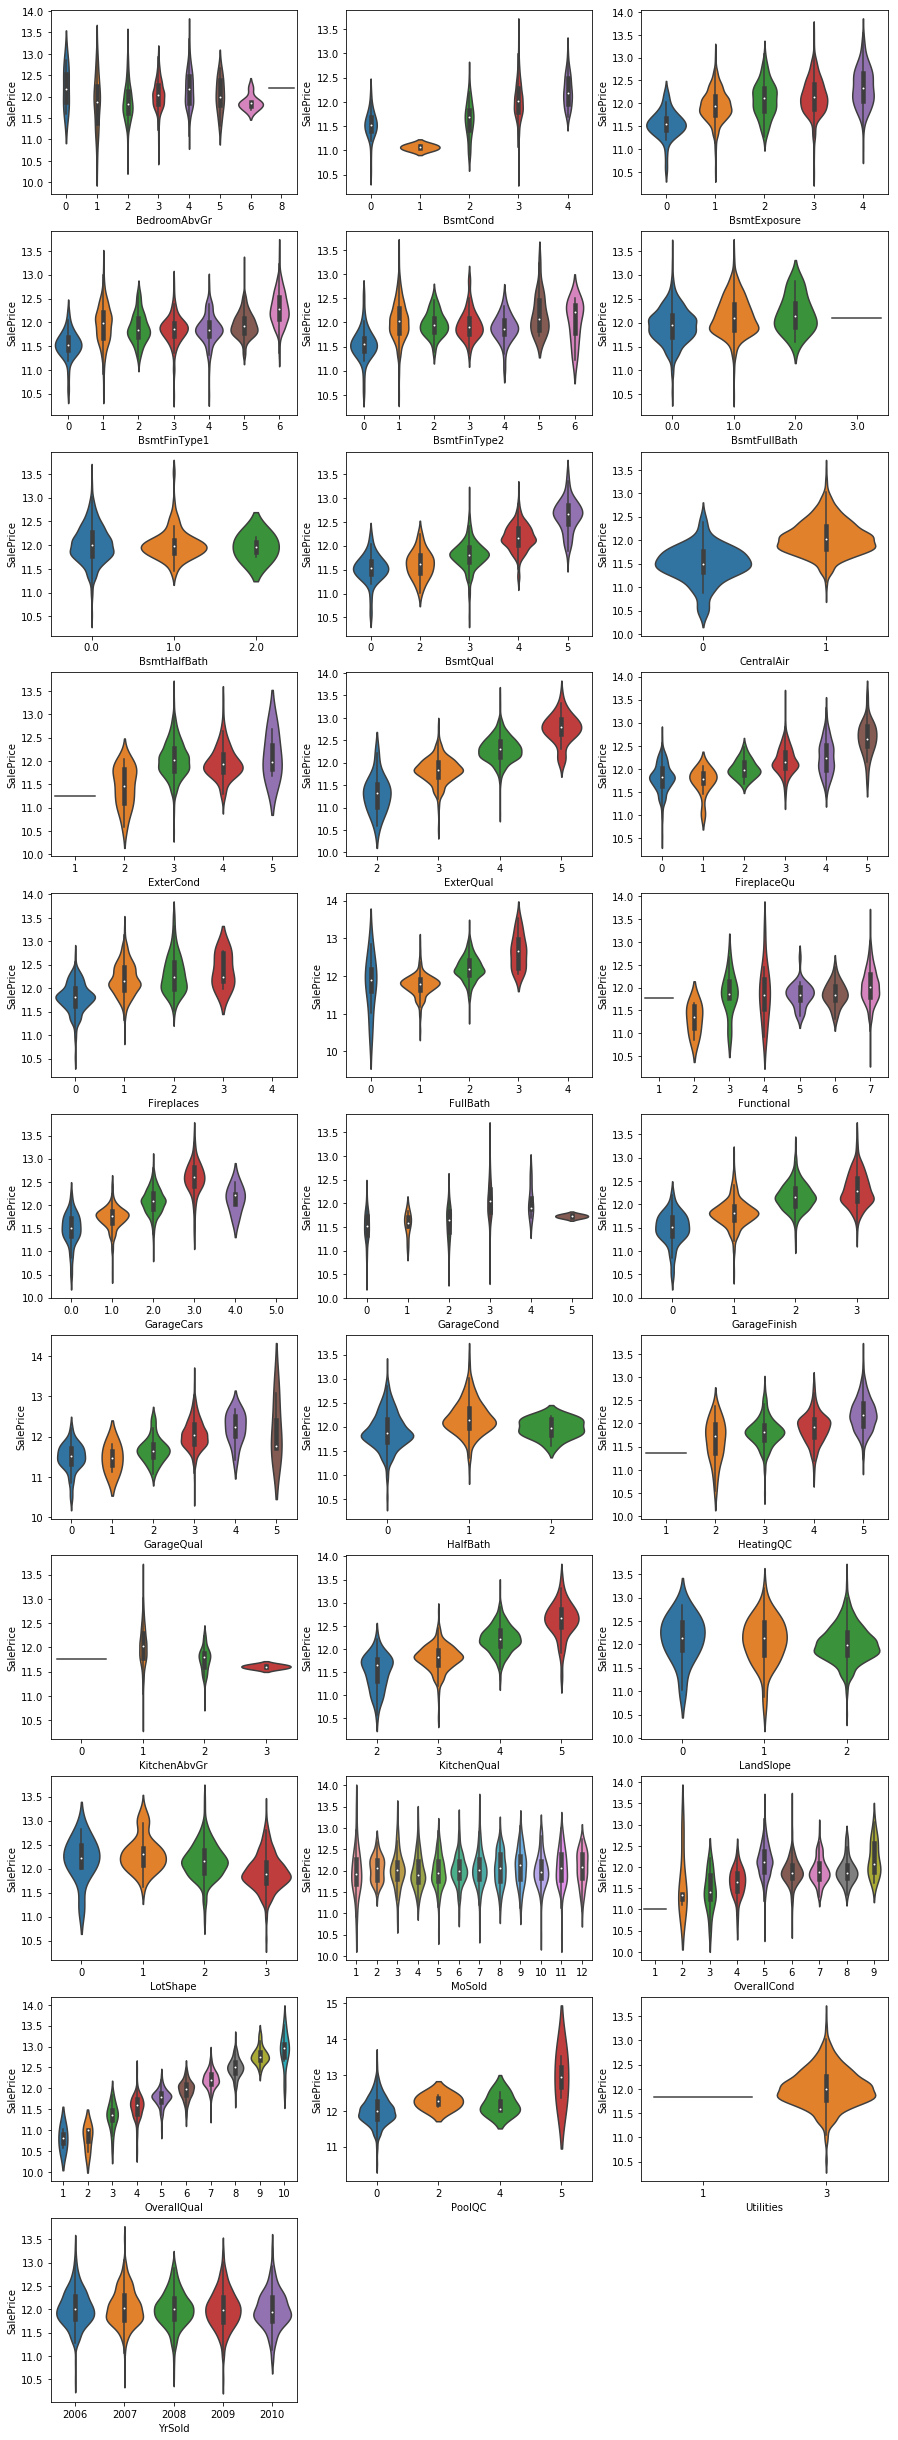

In [19]:
# numeric columns with few values
fcols = 3
frows = ceil(len(cols_discrete)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_discrete):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

## Significance of Discrete Numeric Features for SalePrice

In [20]:
p_col = dict()

for col in cols_discrete:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

OverallQual      0.000000e+00
GarageCars      5.536810e-211
ExterQual       6.930372e-195
BsmtQual        2.029970e-188
KitchenQual     4.438817e-187
GarageFinish    4.058066e-151
FullBath        8.567492e-142
FireplaceQu     6.961918e-115
Fireplaces       7.485284e-97
HeatingQC        1.614912e-82
BsmtFinType1     4.320809e-78
OverallCond      9.272106e-53
GarageCond       2.509004e-47
BsmtExposure     2.590394e-47
GarageQual       6.070436e-46
CentralAir       9.859878e-44
HalfBath         1.323214e-37
LotShape         7.856720e-29
BsmtCond         1.492992e-27
BedroomAbvGr     2.473739e-20
BsmtFullBath     1.424803e-18
ExterCond        6.541282e-14
BsmtFinType2     5.805893e-12
KitchenAbvGr     1.787510e-07
Functional       4.250494e-06
PoolQC           7.695369e-03
LandSlope        3.388339e-01
MoSold           4.496614e-01
YrSold           5.656386e-01
Utilities        6.296086e-01
BsmtHalfBath     9.695371e-01
dtype: float64

## Correlation Between Numeric Features

SalePrice       1.000000
OverallQual     0.809829
GrLivArea       0.731310
GarageCars      0.690711
ExterQual       0.684014
BsmtQual        0.678026
KitchenQual     0.672849
YearBuilt       0.652682
GarageArea      0.649379
FullBath        0.635957
GarageFinish    0.633974
GarageYrBlt     0.612604
TotalBsmtSF     0.602725
1stFlrSF        0.575408
YearRemodAdd    0.571159
FireplaceQu     0.537602
TotRmsAbvGrd    0.532586
Fireplaces      0.519247
HeatingQC       0.491392
OpenPorchSF     0.477561
Name: SalePrice, dtype: float64
-----------------
MiscVal         0.062727
PoolQC          0.058469
PoolArea        0.058453
LandSlope       0.050310
BsmtFinType2    0.039813
BsmtFinSF2      0.038806
YrSold          0.029899
Utilities       0.016710
BsmtHalfBath    0.012189
ExterCond       0.011682
Name: SalePrice, dtype: float64


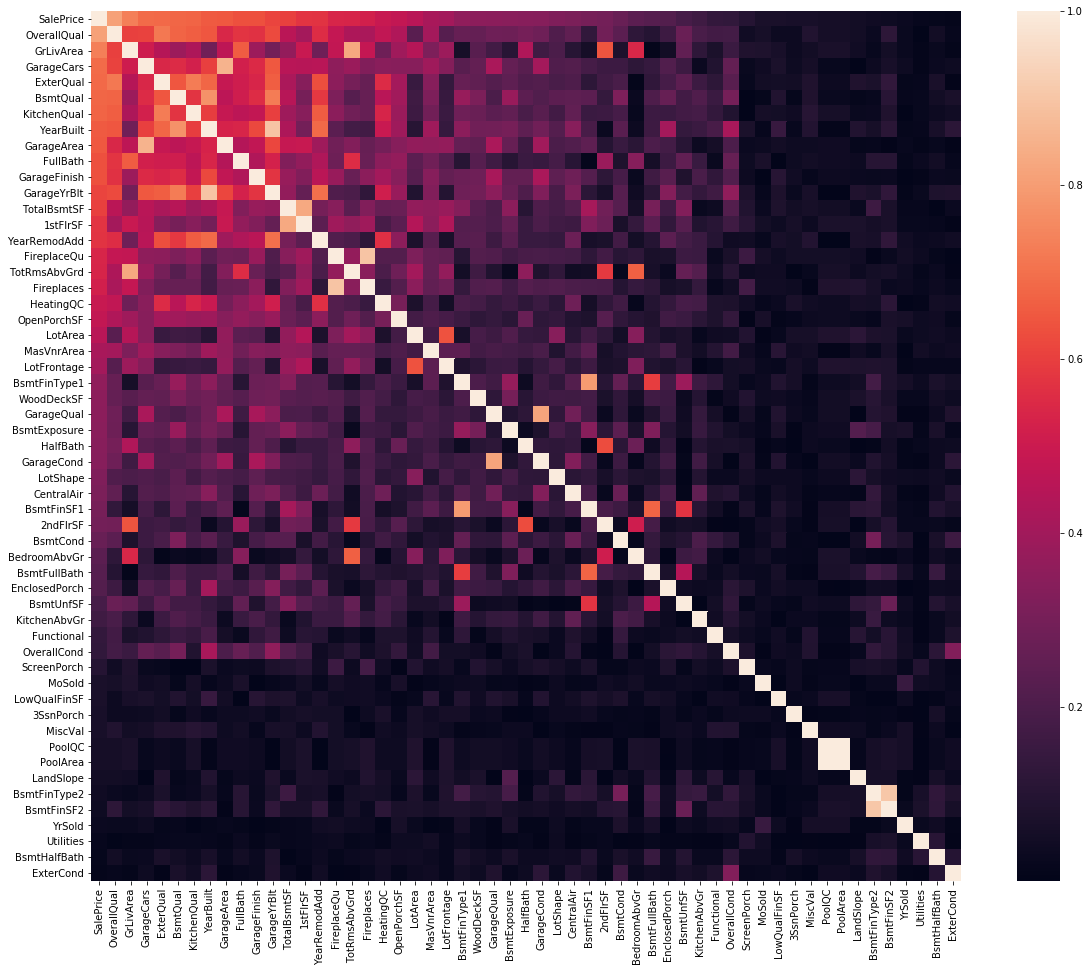

In [21]:
# correlation between numeric variables
df_corr = df_all.loc[id_withprice, cols_numeric].corr(method='spearman').abs()

# order columns and rows by correlation with SalePrice
df_corr = df_corr.sort_values('SalePrice',axis=0,ascending=False).sort_values('SalePrice',axis=1,ascending=False)

print(df_corr.SalePrice.head(20))
print('-----------------')
print(df_corr.SalePrice.tail(10))

ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(df_corr,ax=ax,square=True)

## Collinearity

Many variables strongly correlated, e.g. GarageCars and GarageArea (below).

Kept all features, but feature selection/pca may help some models.

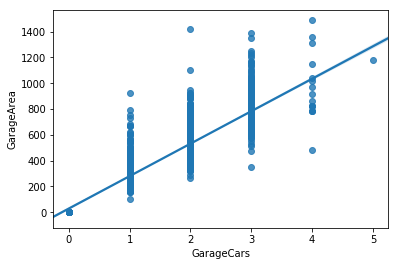

In [22]:
sns.regplot(x='GarageCars',y='GarageArea',data=df_all)

## Normalise Numeric Features

In [23]:
# normalise numeric columns
scale_cols = [col for col in cols_numeric if col!='SalePrice']

df_all[scale_cols] = df_all[scale_cols].apply(scale_minmax,axis=0)

df_all[scale_cols].describe()

1stFlrSF     2ndFlrSF    3SsnPorch  BedroomAbvGr     BsmtCond  \
count  2919.000000  2919.000000  2919.000000   2919.000000  2919.000000   
mean      0.173405     0.162946     0.005123      0.357528     0.729616   
std       0.082412     0.207604     0.049583      0.102837     0.143737   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%       0.113842     0.000000     0.000000      0.250000     0.750000   
50%       0.157110     0.000000     0.000000      0.375000     0.750000   
75%       0.221277     0.340920     0.000000      0.375000     0.750000   
max       1.000000     1.000000     1.000000      1.000000     1.000000   

       BsmtExposure   BsmtFinSF1   BsmtFinSF2  BsmtFinType1  BsmtFinType2  \
count   2919.000000  2919.000000  2919.000000   2919.000000   2919.000000   
mean       0.405961     0.078184     0.032481      0.590271      0.212287   
std        0.267506     0.080724     0.110864      0.352309      0.159197   
min        0.000000     0.000000     0.000000      0.000000      0.000000   
25%        0.250000     0.000000     0.000000      0.166667      0.166667   
50%        0.250000     0.065202     0.000000      0.666667      0.166667   
75%        0.500000     0.129872     0.000000      1.000000      0.166667   
max        1.000000     1.000000     1.000000      1.000000      1.000000   

          ...          PoolArea       PoolQC  ScreenPorch  TotRmsAbvGrd  \
count     ...       2919.000000  2919.000000  2919.000000   2919.000000   
mean      ...          0.002815     0.002741     0.027886      0.342425   
std       ...          0.044580     0.048480     0.097542      0.120721   
min       ...          0.000000     0.000000     0.000000      0.000000   
25%       ...          0.000000     0.000000     0.000000      0.230769   
50%       ...          0.000000     0.000000     0.000000      0.307692   
75%       ...          0.000000     0.000000     0.000000      0.384615   
max       ...          1.000000     1.000000     1.000000      1.000000   

       TotalBsmtSF    Utilities   WoodDeckSF    YearBuilt  YearRemodAdd  \
count  2919.000000  2919.000000  2919.000000  2919.000000   2919.000000   
mean      0.172081     0.999657     0.065807     0.719658      0.571075   
std       0.072196     0.018509     0.088853     0.219503      0.348239   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25%       0.129787     1.000000     0.000000     0.590580      0.250000   
50%       0.161866     1.000000     0.000000     0.731884      0.716667   
75%       0.213093     1.000000     0.117978     0.934783      0.900000   
max       1.000000     1.000000     1.000000     1.000000      1.000000   

            YrSold  
count  2919.000000  
mean      0.448184  
std       0.328741  
min       0.000000  
25%       0.250000  
50%       0.500000  
75%       0.750000  
max       1.000000  

[8 rows x 54 columns]

## The Issue with Zeros

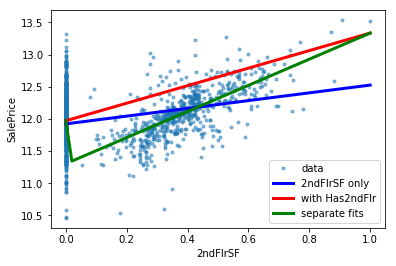

In [24]:
#PROBLEM OF LOTS OF ZEROS - a demonstration
#####
# mode only using 2ndflrsf
#####
tmp = df_all[['SalePrice','2ndFlrSF']].dropna()

y = tmp.SalePrice
X = tmp.drop('SalePrice',axis=1)

plt.plot(X,y,'.',label='data',alpha=0.5)

lr = LinearRegression()
lr.fit(X,y)
lr_coefs = pd.Series(lr.coef_,index=X.columns)
lr_intercept = lr.intercept_

def regval(flr2ndSF):
    return flr2ndSF*lr_coefs['2ndFlrSF'] + lr_intercept

plt.plot([0,1],[regval(0),regval(1)],'b',linewidth=3,label='2ndFlrSF only')

#####
# model using has2ndflr dummy variable
#####
tmp = df_all[['SalePrice','2ndFlrSF']].dropna()
tmp['Has2ndFlr'] = tmp['2ndFlrSF']>0
tmp['Has2ndFlr'] = tmp['Has2ndFlr'].astype(int)

y = tmp.SalePrice
X = tmp.drop('SalePrice',axis=1)

lr = LinearRegression()
lr.fit(X,y)
lr_coefs = pd.Series(lr.coef_,index=X.columns)
lr_intercept = lr.intercept_

def regval(flr2ndSF,has2nd):
    return flr2ndSF*lr_coefs['2ndFlrSF'] + has2nd*lr_coefs['Has2ndFlr'] + lr_intercept

plt.plot([0,1],[regval(0,0),regval(1,1)],'r',linewidth=3,label='with Has2ndFlr')

#####
#model fitting separately for does/doesn't have 2nd flr
#####
lr_has2nd = LinearRegression()
lr_has2nd.fit(X[X.Has2ndFlr==1].drop('Has2ndFlr',axis=1),y[X.Has2ndFlr==1])
lr_has2nd_coefs = pd.Series(lr_has2nd.coef_,index=X.columns)
lr_has2nd_intercept = lr_has2nd.intercept_

lr_no2nd = LinearRegression()
lr_no2nd.fit(X[X.Has2ndFlr==0].drop('Has2ndFlr',axis=1),y[X.Has2ndFlr==0])
lr_no2nd_coefs = pd.Series(lr_no2nd.coef_,index=X.columns)
lr_no2nd_intercept = lr_no2nd.intercept_

def regval(flr2ndSF,has2nd):
    if (has2nd):
        return flr2ndSF*lr_has2nd_coefs['2ndFlrSF'] + lr_has2nd_intercept
    else:
        return flr2ndSF*lr_no2nd_coefs['2ndFlrSF'] + lr_no2nd_intercept


plt.plot([0,0.02,1],[regval(0,0),regval(0.02,1),regval(1,1)],'g',linewidth=3,label='separate fits')


plt.legend()
plt.xlabel('2ndFlrSF')
plt.ylabel('SalePrice');

## Which Numeric Features are Candidates to be Transformed?

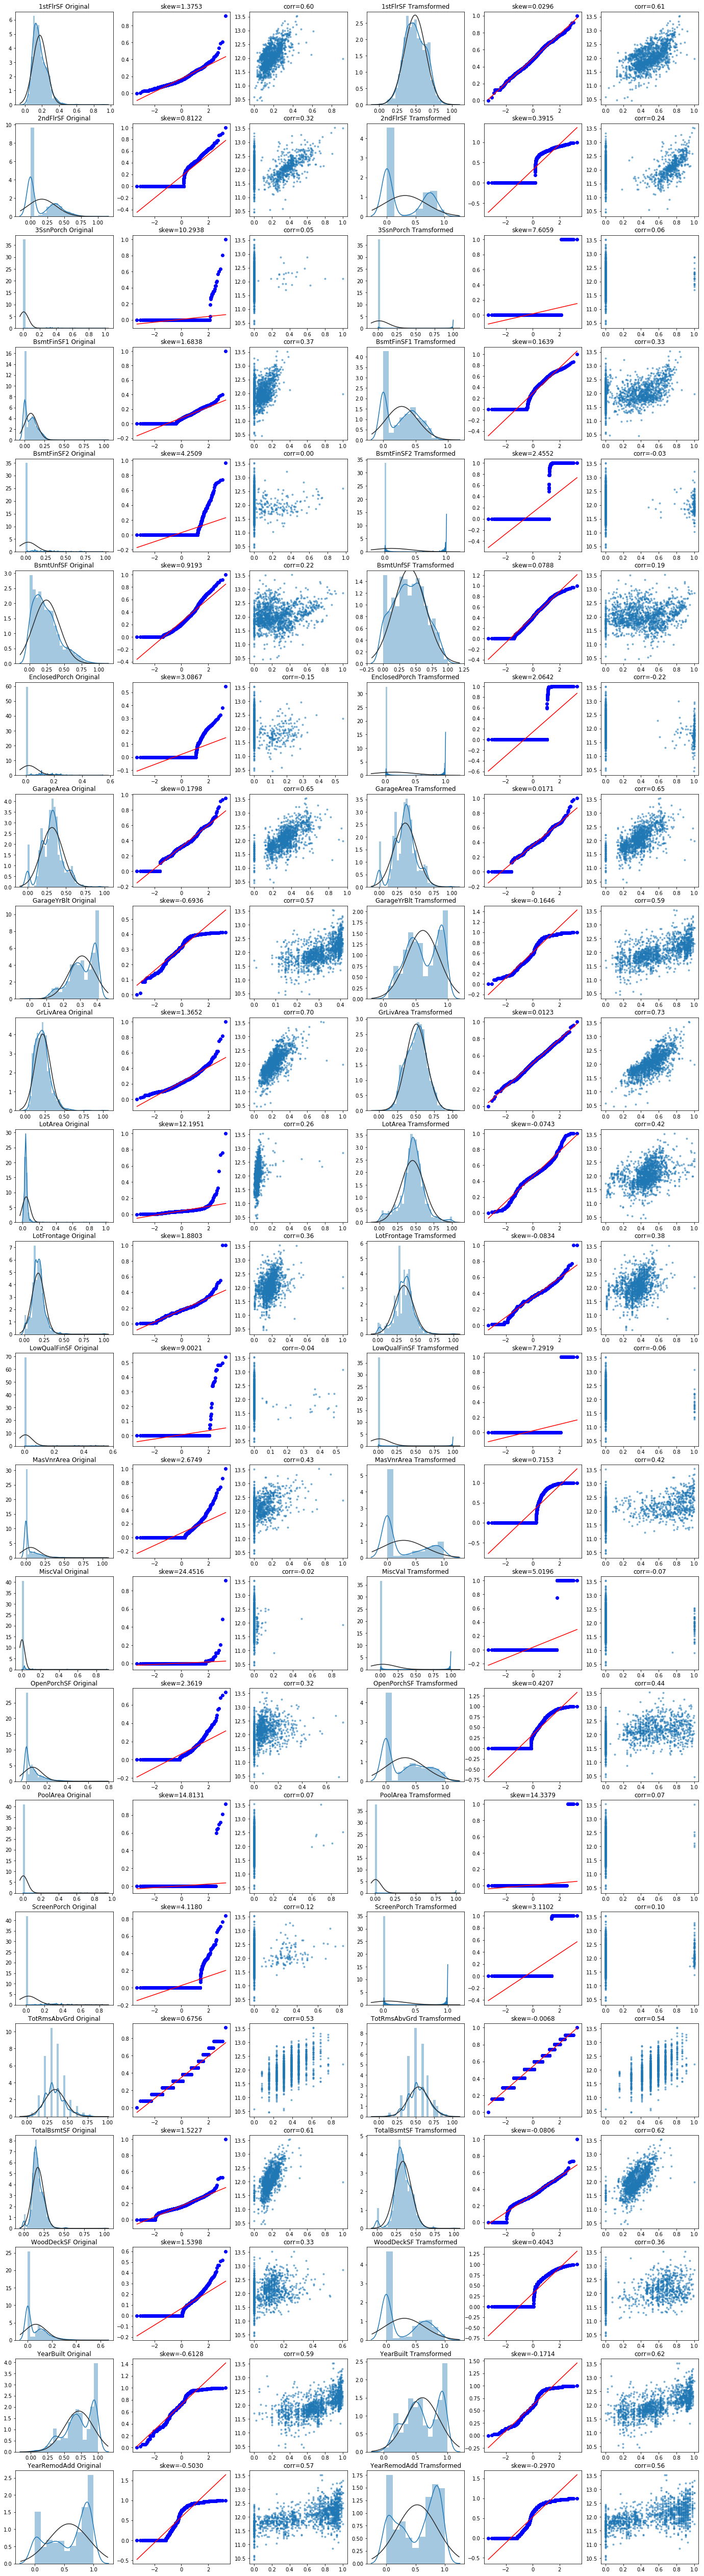

In [25]:
#Check effect of Box-Cox transforms on distributions of continuous variables
fcols = 6
frows = len(cols_continuous)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_continuous:
    if var!='SalePrice':
        dat = df_all[[var, 'SalePrice']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['SalePrice'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['SalePrice'])[0][1]))
 
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = scale_minmax(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['SalePrice'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['SalePrice'])[0][1]))

## Box-Cox Transform Suitable Variables

In [26]:
# variables not suitable for box-cox transformation based on above (usually due to excessive zeros)
# NB - have tried BoxCox on SalePrice, but no improvement or slightly worse
# than log transform. Kept log transform to make it simpler to restore SalePrice predictions.
cols_notransform = ['2ndFlrSF','3SsnPorch','BsmtFinSF2','EnclosedPorch',
                    'LowQualFinSF','MasVnrArea','MiscVal','PoolArea',
                    'ScreenPorch','OpenPorchSF','WoodDeckSF','SalePrice']

cols_transform = [col for col in cols_continuous if col not in cols_notransform]

#transform remaining variables
print('Transforming',len(cols_transform),'columns:',cols_transform)

for col in cols_transform:   
    # transform column
    df_all.loc[:,col], _ = stats.boxcox(df_all.loc[:,col]+1)
    
    # renormalise column
    df_all.loc[:,col] = scale_minmax(df_all.loc[:,col])

Transforming 12 columns: ['1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotRmsAbvGrd', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']


## Prepare Data for Model Fitting

In [27]:
# select features, encode categoricals, create dataframe for model fitting

# select which features to use (all for now)
model_cols = df_all.columns

# encode categoricals
df_model = pd.get_dummies(df_all[model_cols])

# Rather than including Condition1 and Condition2, or Exterior1st and Exterior2nd
# combine the dummy variables (allowing 2 true values per property)
if ('Condition1' in model_cols) and ('Condition2' in model_cols):
    
    cond_suffix = ['Artery','Feedr','Norm','PosA','PosN','RRAe','RRAn','RRNn']
    
    for suffix in cond_suffix:
        col_cond1 = 'Condition1_'+suffix
        col_cond2 = 'Condition2_'+suffix
        
        df_model[col_cond1] = df_model[col_cond1] | df_model[col_cond2]
        df_model.drop(col_cond2,axis=1,inplace=True)
        
if ('Exterior1st' in model_cols) and ('Exterior2nd' in model_cols):
    
    # some different strings in Exterior1st and Exterior2nd for same type - rename columns to correct
    df_model.rename(columns={'Exterior2nd_Wd Shng':'Exterior2nd_WdShing',
                             'Exterior2nd_Brk Cmn':'Exterior2nd_BrkComm',
                             'Exterior2nd_CmentBd':'Exterior2nd_CemntBd'},inplace=True)

    ext_suffix = ['AsphShn','BrkComm','BrkFace','CBlock','CemntBd',
                    'HdBoard','ImStucc','MetalSd','Plywood','Stone',
                    'Stucco','VinylSd','Wd Sdng','WdShing','AsbShng']
    
    for suffix in ext_suffix:
        col_cond1 = 'Exterior1st_'+suffix
        col_cond2 = 'Exterior2nd_'+suffix
        
        df_model[col_cond1] = df_model[col_cond1] | df_model[col_cond2]
        df_model.drop(col_cond2,axis=1,inplace=True)
        
display(df_model.head())

1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  \
Id                                                                        
1   0.362867  0.413559        0.0         0.375      0.75          0.25   
2   0.543162  0.000000        0.0         0.375      0.75          1.00   
3   0.395939  0.419370        0.0         0.375      0.75          0.50   
4   0.416107  0.366102        0.0         0.375      1.00          0.25   
5   0.497820  0.509927        0.0         0.500      0.75          0.75   

    BsmtFinSF1  BsmtFinSF2  BsmtFinType1  BsmtFinType2     ...       \
Id                                                         ...        
1     0.495883         0.0      1.000000      0.166667     ...        
2     0.606483         0.0      0.833333      0.166667     ...        
3     0.380340         0.0      1.000000      0.166667     ...        
4     0.194977         0.0      0.833333      0.166667     ...        
5     0.471450         0.0      1.000000      0.166667     ...        

    SaleType_CWD  SaleType_Con  SaleType_ConLD  SaleType_ConLI  \
Id                                                               
1              0             0               0               0   
2              0             0               0               0   
3              0             0               0               0   
4              0             0               0               0   
5              0             0               0               0   

    SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  Street_Grvl  \
Id                                                                         
1                0             0             0            1            0   
2                0             0             0            1            0   
3                0             0             0            1            0   
4                0             0             0            1            0   
5                0             0             0            1            0   

    Street_Pave  
Id               
1             1  
2             1  
3             1  
4             1  
5             1  

[5 rows x 223 columns]

## Identify and Remove Outliers

In [28]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [29]:
# function to detect outliers based on the predictions of a model
def remove_outliers(model, X, y, sigma=3, drop=True, verbose=False):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>3].index
    
    # print and plot the results if asked
    if verbose:
        print('R2=',model.score(X,y))
        print('rmse=',rmse(y, y_pred))
        print('---------------------------------------')

        print('mean of residuals:',mean_resid)
        print('std of residuals:',std_resid)
        print('---------------------------------------')
        
        print(len(outliers),'outliers:')
        print(outliers.tolist())
        
        plt.figure(figsize=(15,5))
        ax_131 = plt.subplot(1,3,1)
        plt.plot(y,y_pred,'.')
        plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
        plt.legend(['Accepted','Outlier'])
        plt.xlabel('y')
        plt.ylabel('y_pred');

        ax_132=plt.subplot(1,3,2)
        plt.plot(y,y-y_pred,'.')
        plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
        plt.legend(['Accepted','Outlier'])
        plt.xlabel('y')
        plt.ylabel('y - y_pred');

        ax_133=plt.subplot(1,3,3)
        z.plot.hist(bins=50,ax=ax_133)
        z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
        plt.legend(['Accepted','Outlier'])
        plt.xlabel('z')

    # remove outliers from data if requested
    if drop:
        X = X.drop(outliers)
        y = y.drop(outliers)

    return X,y,outliers

In [30]:
# function to get training samples
def get_training_data():
    # extract training samples
    df_train = df_model.loc[id_train]
    
    # split SalePrice and features
    y = df_train.SalePrice
    X = df_train.drop('SalePrice',axis=1)
    
    return X, y

# function to get training samples
def get_holdout_data():
    # extract training samples
    df_holdout = df_model.loc[id_holdout]
    
    # split SalePrice and features
    y = df_holdout.SalePrice
    X = df_holdout.drop('SalePrice',axis=1)
    
    return X, y

# extract test data (without SalePrice)
def get_test_data():
    return df_model.loc[id_test].drop('SalePrice',axis=1)

R2= 0.939121284307
rmse= 0.0997100637592
---------------------------------------
mean of residuals: -6.25070771398547e-16
std of residuals: 0.09975277528984236
---------------------------------------
14 outliers:
[899, 971, 1433, 1299, 1325, 524, 1182, 633, 969, 589, 463, 31, 1454, 875]


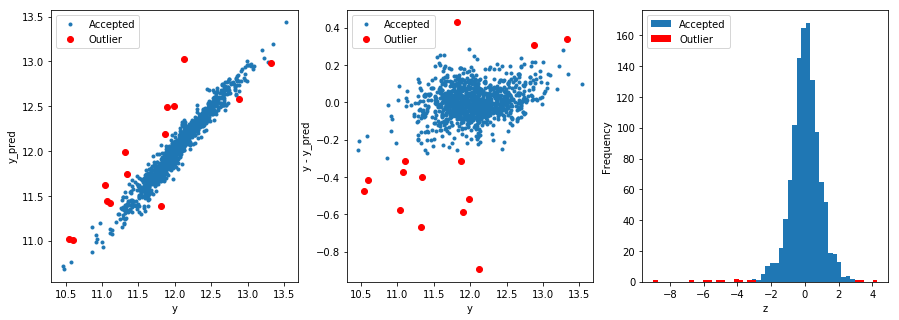

In [31]:
# get training data
X, y = get_training_data()

# find and remove outliers using a Ridge model
X,y,outliers = remove_outliers(Ridge(), X, y, verbose=True)

## First Model - LinearRegression with Regularisation (Ridge)

0.1207 on leaderboard (if fit on all training data, no holdout set)

---------------------------------------
Top 20 contributers to increased price:
---------------------------------------
OverallQual             0.362383
1stFlrSF                0.341188
GrLivArea               0.328389
TotalBsmtSF             0.299601
OverallCond             0.286624
2ndFlrSF                0.263420
LotArea                 0.242080
YearBuilt               0.192634
Functional              0.186074
RoofMatl_WdShngl        0.142500
GarageArea              0.127930
ScreenPorch             0.122488
FullBath                0.119375
Utilities               0.118300
GarageQual              0.118072
BsmtFinSF1              0.108671
Neighborhood_StoneBr    0.105483
WoodDeckSF              0.094304
Exterior1st_BrkFace     0.089497
LotFrontage             0.088192
dtype: float64
---------------------------------------
Top 20 contributers to decreased price:
---------------------------------------
MSZoning_C (all)        -0.278407
Condition1_RRAe         -0.158224
Neighborhood_Mead

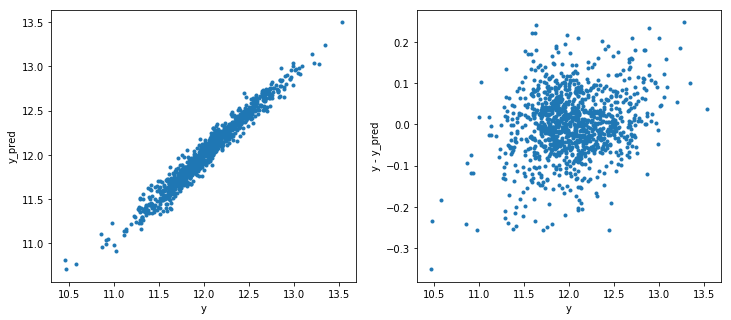

In [32]:
# basic linear model
lr = Ridge()
lr.fit(X,y)
lr_coefs = pd.Series(lr.coef_,index=X.columns)

print('---------------------------------------')
print('Top 20 contributers to increased price:')
print('---------------------------------------')
print(lr_coefs.sort_values(ascending=False).head(20))
print('---------------------------------------')
print('Top 20 contributers to decreased price:')
print('---------------------------------------')
print(lr_coefs.sort_values(ascending=True).head(20))
print('---------------------------------------')
print('Intercept: ',lr.intercept_)
print('---------------------------------------')

y_pred = lr.predict(X)
rms_pred = rmse(y, y_pred)

print('R2=',lr.score(X,y))
print('rmse=',rms_pred)
rkfold = RepeatedKFold(n_splits=5, n_repeats=10)
print('cross_val',
      abs(np.mean(cross_val_score(lr, X, y, 
                                  scoring=rmse_scorer, 
                                  cv=rkfold))))
print('---------------------------------------')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y,y_pred,'.')
plt.xlabel('y')
plt.ylabel('y_pred');

plt.subplot(1,2,2)
plt.plot(y,y-y_pred,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');

## Optimise Model Parameters

In [33]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=10, verbose=True):

    # get unmodified training data, unless data to use already specified
    if len(y)==0:
        X,y = get_training_data()
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring=rmse_scorer,
                               verbose=verbose, return_train_score=True)

        # search the grid
        gsearch.fit(X,y)

        # extract results and best model from the grid
        grid_results = pd.DataFrame(gsearch.cv_results_)
        model = gsearch.best_estimator_
    else:
        grid_results = []
        
    # re-fit the model with the same parameters, but excluding outliers
    X,y,_ = remove_outliers(model, X, y)
    model.fit(X,y)

    # stats on model performance    
    if verbose:      
        print('----------------------')
        print(model)
        print('----------------------')
        print('score=',model.score(X,y))
        print('rmse=',rmse(y, model.predict(X)))
        print('cross_val=',abs(np.mean(cross_val_score(model, X, y, scoring=rmse_scorer, cv=rkfold))))

    return model, grid_results

In [34]:
# dict to store optimal models
opt_models = dict()

# no. k-fold splits
splits=5
# no. k-fold iterations
repeats=5

## Linear Regression

### Ridge

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:   19.4s finished


----------------------
Ridge(alpha=2.75, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.957226840528
rmse= 0.0814809287997
cross_val= 0.098648852174


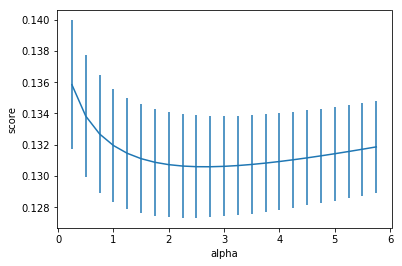

In [35]:
opt_models['Ridge'] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models['Ridge'],cv_results = train_model(opt_models['Ridge'], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

plt.errorbar(alph_range, abs(cv_results['mean_test_score']),
             abs(cv_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

### Lasso

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:   19.4s finished


----------------------
Lasso(alpha=0.00038000000000000008, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.953933704803
rmse= 0.0845121640251
cross_val= 0.0956468812019


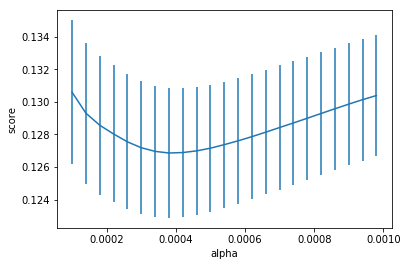

In [36]:
opt_models['Lasso'] = Lasso()
alph_range = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alph_range}

opt_models['Lasso'], cv_results = train_model(opt_models['Lasso'], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

plt.errorbar(alph_range, abs(cv_results['mean_test_score']),abs(cv_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

### ElasticNet

In [37]:
opt_models['ElasticNet'] = ElasticNet()
param_grid = {'alpha': np.arange(0.1,1.1,0.1),
              'l1_ratio': np.arange(0.1,1.0,0.1)}

opt_models['ElasticNet'], cv_results = train_model(opt_models['ElasticNet'], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)


Fitting 25 folds for each of 90 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed:   45.0s finished


----------------------
ElasticNet(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
      l1_ratio=0.10000000000000001, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.729510332176
rmse= 0.196006536035
cross_val= 0.198659903379


## SVM

### Linear

Fitting 25 folds for each of 9 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   43.9s finished


----------------------
LinearSVR(C=0.40000000000000002, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
----------------------
score= 0.955654667103
rmse= 0.0832626789433
cross_val= 0.107923545069


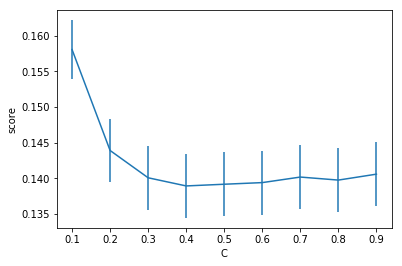

In [38]:
opt_models['LinearSVR'] = LinearSVR()

crange = np.arange(0.1,1.0,0.1)
param_grid = {'C':crange}

opt_models['LinearSVR'], cv_results = train_model(opt_models['LinearSVR'], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

plt.errorbar(crange, abs(cv_results['mean_test_score']),abs(cv_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('C')
plt.ylabel('score');

### Non-Linear

In [39]:
opt_models['SVR'] = SVR()

param_grid = {'C':np.arange(1,21,2),
              'kernel':['poly','rbf','sigmoid']}

opt_models['SVR'], cv_results = train_model(opt_models['SVR'], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

Fitting 25 folds for each of 30 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:  4.2min finished


----------------------
SVR(C=11, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
----------------------
score= 0.961369553591
rmse= 0.0775477958753
cross_val= 0.102803429589


## KNeighbors

Fitting 25 folds for each of 8 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.9min finished


----------------------
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=6, p=2,
          weights='uniform')
----------------------
score= 0.852453170792
rmse= 0.147281219137
cross_val= 0.182340298923


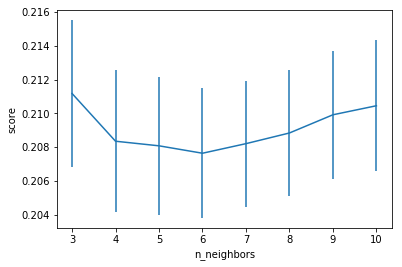

In [40]:
opt_models['KNeighbors'] = KNeighborsRegressor()

param_grid = {'n_neighbors':np.arange(3,11,1)}

opt_models['KNeighbors'], cv_results = train_model(opt_models['KNeighbors'], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

plt.errorbar(np.arange(3,11,1), abs(cv_results['mean_test_score']),abs(cv_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('n_neighbors')
plt.ylabel('score');

## Tree-Based

### Random Forest

In [41]:
opt_models['RandomForest'] = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[25,50,75],
              'min_samples_split':[2,4,6]}

opt_models['RandomForest'], cv_results = train_model(opt_models['RandomForest'], param_grid=param_grid, 
                                              splits=5, repeats=1)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.6min finished


----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=50, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
----------------------
score= 0.986533737093
rmse= 0.0447084356464
cross_val= 0.120104183391


### Gradient Boosting

In [42]:
opt_models['GradientBoosting'] = GradientBoostingRegressor()

param_grid = {'n_estimators':[100,175,250],
              'max_depth':[2,3,4],
              'min_samples_split':[5,6,7]}

opt_models['GradientBoosting'], cv_results = train_model(opt_models['GradientBoosting'], param_grid=param_grid, 
                                              splits=splits, repeats=1)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.5min finished


----------------------
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=250, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
----------------------
score= 0.96836613758
rmse= 0.0709512879558
cross_val= 0.123943021045


### XGBoost

In [43]:
opt_models['XGB'] = XGBRegressor()

param_grid = {'n_estimators':[100,200,300,400,500],
              'max_depth':[1,2,3],
             }

opt_models['XGB'], cv_results = train_model(opt_models['XGB'], param_grid=param_grid, 
                                              splits=5, repeats=1)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.6min finished


----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
----------------------
score= 0.977690193069
rmse= 0.0599760537582
cross_val= 0.115981160672


## PCA then Ridge with 2nd Order Terms

Fitting 50 folds for each of 11 candidates, totalling 550 fits


[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:  1.5min finished


----------------------
Ridge(alpha=45, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.982511477068
rmse= 0.0517816777491
cross_val= 0.109477403485


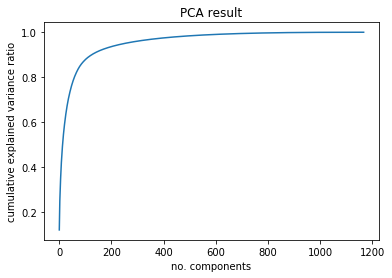

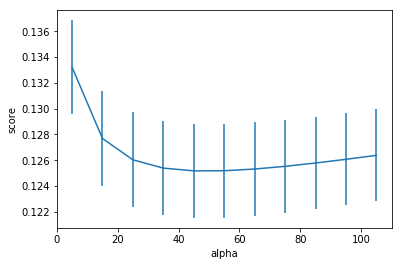

In [44]:
X,y=get_training_data()

# get 2nd order terms
poly = PolynomialFeatures()
X = poly.fit_transform(X,y)

# reduce dimensionality using PCA
# n_components = len(X) by default
# (as no. polynomial features >> len(x))
pca = PCA()
X = pca.fit_transform(X,y)
X = pd.DataFrame(X,index=y.index)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no. components')
plt.ylabel('cumulative explained variance ratio')
plt.title('PCA result')

alph_range = np.arange(5,75,5)
param_grid = {'alpha':alph_range}
ridge, cv = train_model(Ridge(),X=X,y=y,param_grid=param_grid)

plt.figure()
plt.errorbar(alph_range, abs(cv['mean_test_score']),abs(cv['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

# combine results in to a pipeline
opt_models['PolyPCA'] = Pipeline([('Poly',poly),('PCA',pca),('Ridge',ridge)])

## Compare Models

Lasso               0.105265
Ridge               0.108964
PolyPCA             0.111610
SVR                 0.112822
LinearSVR           0.112885
GradientBoosting    0.119629
XGB                 0.121889
RandomForest        0.131551
KNeighbors          0.193024
ElasticNet          0.214283
dtype: float64

Ridge     Lasso  ElasticNet  LinearSVR       SVR  \
Ridge             1.000000  0.996871    0.910624   0.988790  0.997144   
Lasso             0.996871  1.000000    0.907800   0.989666  0.993154   
ElasticNet        0.910624  0.907800    1.000000   0.891613  0.912876   
LinearSVR         0.988790  0.989666    0.891613   1.000000  0.983128   
SVR               0.997144  0.993154    0.912876   0.983128  1.000000   
KNeighbors        0.894322  0.887388    0.908375   0.880304  0.898421   
RandomForest      0.968373  0.969516    0.924104   0.958168  0.968288   
GradientBoosting  0.983618  0.987205    0.904328   0.975048  0.981146   
XGB               0.982814  0.985810    0.897337   0.975244  0.980514   
PolyPCA           0.993723  0.991077    0.910020   0.984412  0.993954   

                  KNeighbors  RandomForest  GradientBoosting       XGB  \
Ridge               0.894322      0.968373          0.983618  0.982814   
Lasso               0.887388      0.969516          0.987205  0.985810   
ElasticNet          0.908375      0.924104          0.904328  0.897337   
LinearSVR           0.880304      0.958168          0.975048  0.975244   
SVR                 0.898421      0.968288          0.981146  0.980514   
KNeighbors          1.000000      0.908879          0.887983  0.887046   
RandomForest        0.908879      1.000000          0.977242  0.969769   
GradientBoosting    0.887983      0.977242          1.000000  0.994934   
XGB                 0.887046      0.969769          0.994934  1.000000   
PolyPCA             0.904922      0.970612          0.982839  0.982404   

                   PolyPCA  
Ridge             0.993723  
Lasso             0.991077  
ElasticNet        0.910020  
LinearSVR         0.984412  
SVR               0.993954  
KNeighbors        0.904922  
RandomForest      0.970612  
GradientBoosting  0.982839  
XGB               0.982404  
PolyPCA           1.000000

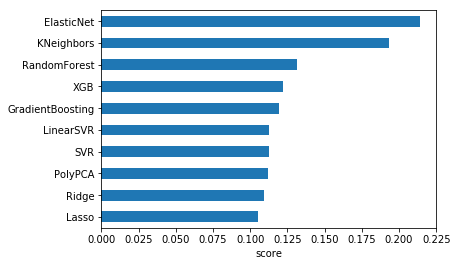

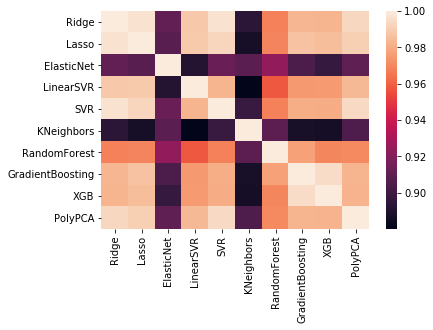

In [56]:
X,y = get_holdout_data()

Y_models = pd.DataFrame(index=y.index)    
score_models = pd.Series(index=opt_models.keys())

for key, model in opt_models.items():
    Y_models[key] = model.predict(X)
    score_models[key] = rmse(y, Y_models[key])

    
score_models = score_models.sort_values()

corr_models = pd.DataFrame(Y_models).corr()

display(score_models)
score_models.plot.barh()
plt.xlabel('score')

plt.figure()
display(corr_models)
sns.heatmap(corr_models)

In [61]:
1/score_models**2

Lasso               90.247636
Ridge               84.224137
PolyPCA             80.277005
SVR                 78.561591
LinearSVR           78.474706
GradientBoosting    69.875754
XGB                 67.308783
RandomForest        57.784710
KNeighbors          26.839649
ElasticNet          21.778371
dtype: float64

## Combine Models

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


----------------------
Ridge(alpha=0.95000000000000007, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)
----------------------
score= 0.937664636487
rmse= 0.0926085922474
cross_val= 0.0947786792651
----------------------
Intercept: 0.197909078427
Lasso               0.217081
LinearSVR           0.216656
RandomForest        0.200071
Ridge               0.136177
PolyPCA             0.106879
SVR                 0.097427
GradientBoosting    0.060408
XGB                 0.048777
KNeighbors          0.003985
ElasticNet         -0.103525
dtype: float64


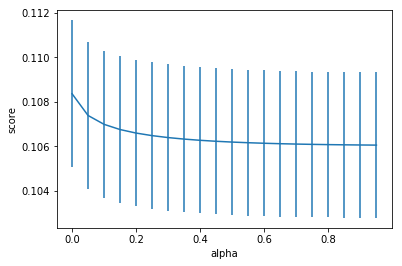

In [59]:
def fit_ensemble(ensemble_model, base_models, param_grid=[]):
    
    X,y = get_holdout_data()
    
    Y_models = pd.DataFrame(index=y.index)    
    
    for key, model in base_models.items():
        Y_models[key] = model.predict(X)
    
    ensemble_model, grid_results= train_model(ensemble_model, X=Y_models, y=y, param_grid=param_grid)
    
    return ensemble_model, grid_results

alphrange = np.arange(0,1.5,0.05)
param_grid = {'alpha':alphrange}
ensemble, grid_results = fit_ensemble(Ridge(alpha=2), opt_models,param_grid=param_grid) 
print('----------------------')
print('Intercept:',ensemble.intercept_)
print(pd.Series(ensemble.coef_,index=opt_models.keys()).sort_values(ascending=False))

#lin_models = {k: v for k, v in opt_models.items() if k in ['Lasso','Ridge']}
#ensemble, grid_results = fit_ensemble(Ridge(alpha=2), lin_models,param_grid=param_grid) 
#print('----------------------')
#print('Intercept:',ensemble.intercept_)
#print(pd.Series(ensemble.coef_,index=lin_models.keys()).sort_values(ascending=False))

plt.errorbar(alphrange, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');


## Predict SalePrice for the Test Data

In [47]:
# predict one model
def predict_test(model):
    # get test data
    X_test = get_test_data()

    # predict SalePrices
    y_test = model.predict(X_test)

    #revert log transformation
    y_test = np.exp(y_test)-1

    y_test = pd.DataFrame(y_test,index=X_test.index)
    y_test.columns = ['SalePrice']
    
    return y_test

# predict using ensemble of models
def predict_ensemble(ensemble_model, base_models):
    # get test data
    X = get_test_data()
    
    Y_models = pd.DataFrame(index=X.index)    
    
    for key, model in base_models.items():
        Y_models[key] = model.predict(X)
        
    y_test = ensemble_model.predict(Y_models)
    
    #revert log transformation
    y_test = np.exp(y_test)-1
    
    y_test = pd.DataFrame(y_test, index=X.index)
    y_test.columns = ['SalePrice']
    
    return y_test

# predict using average of models
def predict_average(models):
    # get test data
    X = get_test_data()
    
    Y_models = pd.DataFrame(index=X.index)    
    
    for key, model in models.items():
        Y_models[key] = model.predict(X)
        
    y_test = Y_models.mean(axis=1)
    
    #revert log transformation
    y_test = np.exp(y_test)-1
    
    y_test = pd.DataFrame(y_test, index=X.index)
    y_test.columns = ['SalePrice']
    
    return y_test

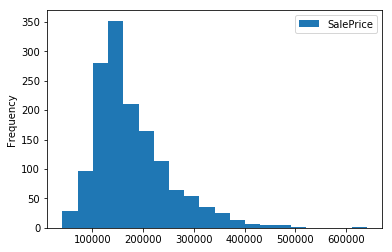

In [63]:
#y_test = predict_ensemble(ensemble, opt_models)
#y_test = predict_ensemble(ensemble, lin_models)
#y_test = predict_average(opt_models)
y_test = predict_test(opt_models['Lasso'])

y_test.plot.hist(bins=20)

# make submission file
y_test.to_csv('submission.csv')

In [49]:
#Think about:
# Holdout data for ensemble model training
# Outlier removal - may be harmful some cases?
# Why RandomForestRegressor seems to dominate ensemble model, even though cv score worse